In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import os
import time
from pathlib import Path
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import math

In [11]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes

num_train = metadata.splits['train'].num_examples * 0.8
num_validation = metadata.splits['train'].num_examples * 0.1
num_test = metadata.splits['train'].num_examples * 0.1

print(num_classes)
print(num_train)
print(num_validation)
print(num_test)

# augment the data
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

120
9600.0
1200.0
1200.0


In [30]:
def random_shift(image, max_shift=20):
    # Pad the image by max_shift pixels on all sides
    padded_image = tf.image.pad_to_bounding_box(image, max_shift, max_shift, 
                                                tf.shape(image)[0] + 2 * max_shift, 
                                                tf.shape(image)[1] + 2 * max_shift)
    
    # Randomly crop back to the original size to simulate a shift
    cropped_image = tf.image.random_crop(padded_image, size=[tf.shape(image)[0], tf.shape(image)[1], 3])
    
    return cropped_image

def preprocess_augment_image(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.cast(image, tf.float32) / 255.0

    image = random_shift(image, max_shift=20)
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    # image = keras.applications.xception.preprocess_input(image)
    return image, label

def preprocess_image(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.cast(image, tf.float32) / 255.0
    # image = keras.applications.xception.preprocess_input(image)

    return image, label

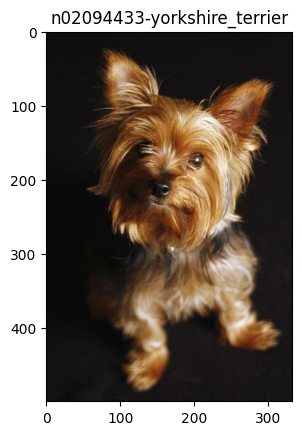

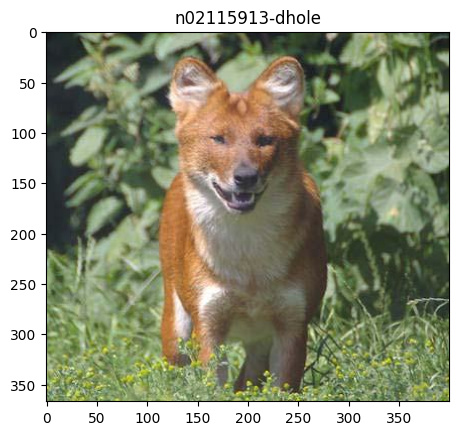

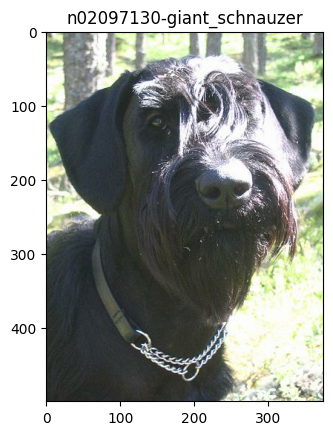

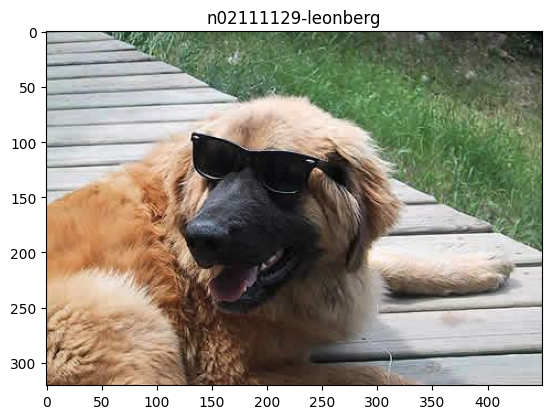

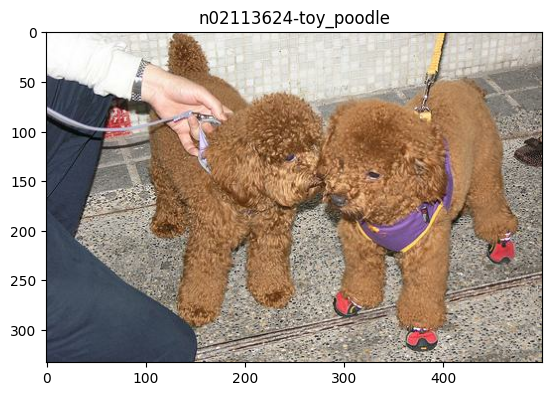

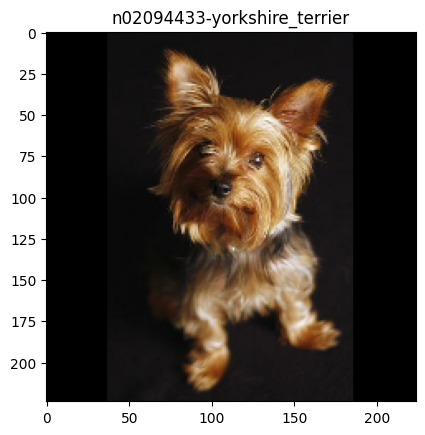

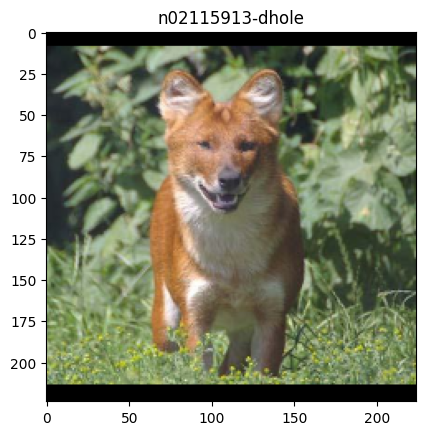

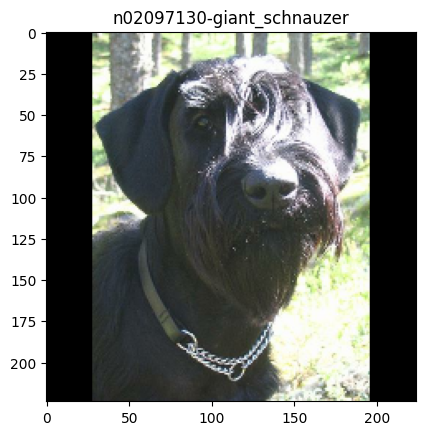

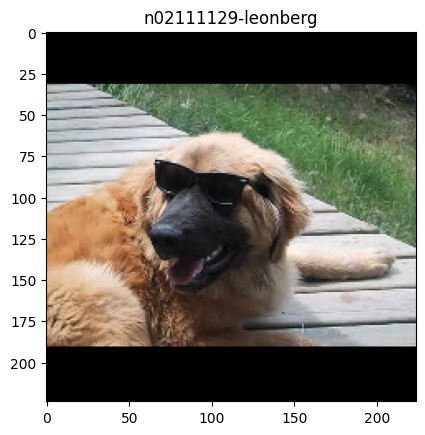

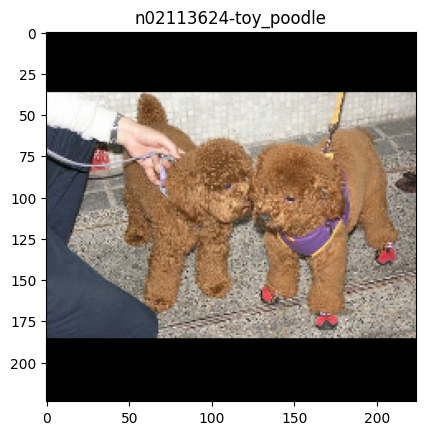

In [31]:
# show some dog images

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

for image, label in raw_train.take(5):
    image, label = preprocess_image(image, label)
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train = raw_train.map(preprocess_image).shuffle(1000).repeat().batch(batch_size).prefetch(AUTOTUNE)
validation = raw_validation.map(preprocess_image).repeat().batch(batch_size).prefetch(AUTOTUNE)
test = raw_test.map(preprocess_augment_image).batch(batch_size).prefetch(AUTOTUNE)
test_no_aug = raw_test.map(preprocess_image).batch(batch_size).prefetch(AUTOTUNE)

base_model = keras.applications.Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

random_rotation = keras.layers.RandomRotation(factor=0.15)

for layer in base_model.layers:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = random_rotation(inputs)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
# optimizer = keras.optimizers.Nadam(learning_rate=1e-1)
optimizer = keras.optimizers.SGD(learning_rate=2e-1, momentum=0.9, weight_decay=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
# model.evaluate(test)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 120)            │       245,880 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,107,360 (80.52 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [36]:
frozen_model_name = 'xception_no_aug_frozen_20epoch_early_stop.keras'
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
history = model.fit(train,
                    steps_per_epoch=int(0.35 * num_train / batch_size),
                    validation_data=validation,
                    validation_steps=int(0.15 * num_validation / batch_size),
                    epochs=20,
                    callbacks=[early_stopping_cb, lr_scheduler])
model.save(frozen_model_name)
model.evaluate(test)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.7846 - loss: 1.2608 - val_accuracy: 0.6500 - val_loss: 2.8542 - learning_rate: 6.2500e-04
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 930s 9s/step - accuracy: 0.7665 - loss: 1.3263 - val_accuracy: 0.7375 - val_loss: 1.8323 - learning_rate: 6.2500e-04
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.7624 - loss: 1.3999 - val_accuracy: 0.7500 - val_loss: 1.2132 - learning_rate: 6.2500e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.7883 - loss: 1.2149 - val_accuracy: 0.7125 - val_loss: 2.0583 - learning_rate: 6.2500e-04
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7660 - loss: 1.3276 - val_accuracy: 0.7312 - val_loss: 2.1634 - learning_rate: 6.2500e-04
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.7586 - loss: 1.3623 - val_accuracy: 0.7188 - val_loss: 2.2439 - learning_rate: 3.1250e-04
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - acc

[2.1365859508514404, 0.7200000286102295]

In [22]:
model = keras.models.load_model(frozen_model_name)
loss, accuracy = model.evaluate(test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7255 - loss: 2.2178
Test accuracy: 71.58%


In [23]:
unfrozen_model_name = 'xception_40epoch_early_stop.keras'

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9,
                                 nesterov=True, weight_decay=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

model.fit(train,
          steps_per_epoch=int(0.35 * num_train / batch_size),
          validation_data=validation,
          validation_steps=int(0.15 * num_validation / batch_size),
          epochs=40,
          callbacks=[early_stopping_cb, lr_scheduler])

model.save(unfrozen_model_name)


Epoch 1/40


c:\programming\ml\my_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7458 - loss: 1.5689 - val_accuracy: 0.6750 - val_loss: 2.7837 - learning_rate: 0.0100
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7542 - loss: 1.3590 - val_accuracy: 0.7625 - val_loss: 1.5674 - learning_rate: 0.0100
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 922s 9s/step - accuracy: 0.7254 - loss: 1.6768 - val_accuracy: 0.7563 - val_loss: 1.4518 - learning_rate: 0.0100
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.7658 - loss: 1.2232 - val_accuracy: 0.6875 - val_loss: 2.0651 - learning_rate: 0.0100
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7549 - loss: 1.4755 - val_accuracy: 0.6938 - val_loss: 2.3379 - learning_rate: 0.0100
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.7398 - loss: 1.3822 - val_accuracy: 0.7625 - val_loss: 2.0517 - learning_rate: 0.0050
Epoch 7/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.7735 - loss: 1.1909 - val_

In [34]:
model = keras.models.load_model('xception_20epoch_early_stop.keras')

loss, accuracy = model.evaluate(test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

loss, accuracy = model.evaluate(test_no_aug)
print(f"Test accuracy without data augmentation: {round(accuracy * 100, 2)}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7285 - loss: 2.1182
Test accuracy: 73.08%
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7114 - loss: 2.0912
Test accuracy without data augmentation: 71.33%


In [44]:
model = keras.models.load_model('xception_frozen_20epoch_early_stop.keras')

for i in range(1, int(len(base_model.layers)/30) + 1):
    if i == int(len(base_model.layers)/30):
        print(f"Unfreezing all the layers")
        for layer in base_model.layers:
            layer.trainable = True
    else:
        print(f"Unfreezing the last {30*i} layers")
        for layer in base_model.layers[-(30*i):]:
            layer.trainable = True

    optimizer = keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9,
                                    nesterov=True, weight_decay=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

    model.fit(train,
                steps_per_epoch=int(0.45 * num_train / batch_size),
                validation_data=validation,
                epochs=80,
                callbacks=[early_stopping_cb, lr_scheduler])
    
    loss, accuracy = model.evaluate(test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    loss, accuracy = model.evaluate(test_no_aug)
    print(f"Test accuracy without data augmentation: {round(accuracy * 100, 2)}%")

    if i == int(len(base_model.layers)/30):
        model.save(f'xception_all_thawed_early_stop.keras')
    else:
        model.save(f'xception_{30*i}_top_thawed_early_stop.keras')

Unfreezing the last 30 layers
Epoch 1/80
114/135 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7293 - loss: 1.7879

KeyboardInterrupt: 